# Brain Tumor Analysis

In this project we are going to predict wether if it is a **Brain Tumor** or not, using **Magnetic Resonance Imaging** *(MRI)*, from Kaggle.


## **Prepare Data**

### *Getting Dataset*
Here we extract our data and give the right label to each image.

In [1]:
import os
import pandas as pd

paht_yes = "brain_tumor_datasets/yes"
path_no = "brain_tumor_datasets/no"

data = []

def extract_images(folder, label):
    for filename in os.listdir(folder):
        filepath = os.path.join(folder, filename)
        if os.path.isfile(filepath):
            data.append({"image": filepath, "label": label})

extract_images(paht_yes, label=1)
extract_images(path_no, label=0)

df = pd.DataFrame(data)
df

,image,label
0,brain_tumor_datasets/yes\Y1.jpg,1
1,brain_tumor_datasets/yes\Y10.jpg,1
2,brain_tumor_datasets/yes\Y100.JPG,1
3,brain_tumor_datasets/yes\Y101.jpg,1
4,brain_tumor_datasets/yes\Y102.jpg,1
...,...,...
248,brain_tumor_datasets/no\No18.jpg,0
249,brain_tumor_datasets/no\No19.jpg,0
250,brain_tumor_datasets/no\No20.jpg,0
251,brain_tumor_datasets/no\No21.jpg,0


Here we used *os* and *pandas* libraries to create a dataframe and insert all the images by their labels. We firstly created 2 variables named *'path_yes'* and *'path_no'*, to append all the images that is or not a Tumor.

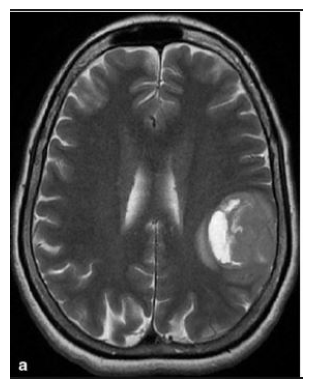

Cancer (1/0) -> 1


In [8]:
# show the first image just to be sure ist everything alright
from matplotlib import pyplot as plt
from PIL import Image

def get_image_by_pos(df, image_feature, label_feature, pos):
    img_path = df[image_feature][pos]

    img = Image.open(img_path)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
    print(f"Cancer (1/0) -> {df[label_feature][pos]}")

get_image_by_pos(df, image_feature='image', label_feature='label', pos=154)

Just to check that the images were correctly appended, we created a function that receive the dataset, the name of the feature with all the images path, the label feature and the position that want to show, to return the image of the brain and if has cancer or not.
As we can see our images are extracted correclty.

### *Shuffle Dataset*
As we can see, our dataset has some complications, such as the data not being mixed up, in other words, the first images show those without cancer, while the following images show those with cancer. This is a problem because when we want to train the model and divid it into training, validation and test data, the model won't be able to lean the patterns of waht a 'cancer' is. For example, if we splt the dataset at the moment so that the first images are in the training data and the last images are in the test data, there's a huge chance that the model will only be able to learn from the images of the brain without cance, and that when ir comes to testing it will only pick up the images that have cancer. as a result, the model won't be able to learn any pattern and will only be able to predict images that don't have cancer. However, we'll mix up the data so that when we train the neural network, the model can learn all possible patterns.

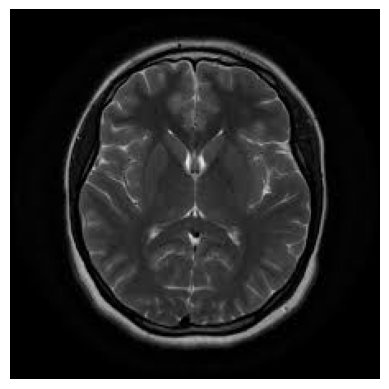

Cancer (1/0) -> 0


In [24]:
df = df.sample(frac=1).reset_index(drop=True)
get_image_by_pos(df, image_feature='image', label_feature='label', pos=250)

As we can see now, our dataset has been shuffle correctly.